# Example 1

## Overview

This notebook reviews

- some of the aspects of the central limit theorem,
- confidence intervals,
- and hypothesis testing.

As usual we will start by importing some useful libraries. Recall from the
[previous
notebook](https://github.com/aezarebski/aas-extended-examples/tree/main/example-0)
that it is good practise to import these packages with the standard
abbreviations of their names.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Central limit theorem

The central limit theorem (CLT) tells us about the limiting distribution
of the sample mean for distribution for an independent and identically
distributed (IID) sample with a finite variance. It underpins many
results in statistics and is important for reasoning about stochastic
processes.

### Question

Write down a statement of the law of large numbers (LLN). Write down a
statement of the central limit theorem. Make sure you understand what
each of them tells you.

### Answer

-   $\hat{X}$ converges to $\mu$.
-   $\sqrt{n}(\hat{X} - \mu) / \sigma$ converges in distribution to the
    standard normal distribution as the sample size increases.
-   The LLN tells you what the limiting value is, the CLT tells you
    about the fluctuations in the estimate.

Example: CLT
------------

To see that the distribution of the sample mean converges to a normal
distribution we will do a simulation study.

### Question

Write down the distribution of the sample mean given an IID sample of
exponential random variables with rate $1/5$.

### Answer

-   The mean of the exponential distribution is 5.
-   The standard deviation of the exponential distribution is 5
-   The CLT tells us the limiting distribution for the sample mean is
    $N\left(5,\frac{5^2}{n}\right)$

### Question

1.  Generate 500 sample means each based on a sample of 100 exponential
    random variables
2.  Make a visualisation of the distribution of the data (e.g., a KDE or
    histogram) and overlay the CLT approximation.

### Answer

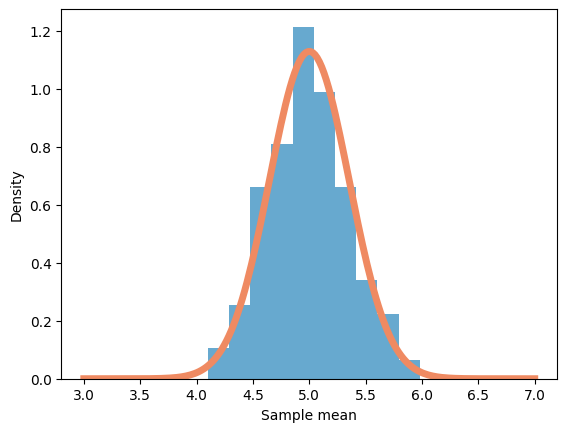

In [2]:
sample_size = 200
num_replicates = 500

sample_means = [stats.expon.rvs(scale = 5, size = sample_size).mean()
                for _ in range(num_replicates)]

plot_df = pd.DataFrame({"sample_mean": sample_means})

mesh_size = 200

x_vals = np.linspace(3, 7, num=200)

clt_scale = 5 / np.sqrt(sample_size)

clt_df = pd.DataFrame(
    {
        "x": x_vals,
        "pdf": stats.norm.pdf(x_vals, loc = 5, scale = clt_scale)
    }
)

plt.figure()
plt.hist(plot_df.sample_mean, density=True,  color="#67a9cf")
plt.plot(clt_df.x, clt_df.pdf, color="#ef8a62", linewidth=5)
plt.xlabel("Sample mean")
plt.ylabel("Density")
plt.show()

## Estimating the mean of a small sample

If we have a sample from a normal distribution with sample mean $\bar{x}$ and
known the standard deviation, $\sigma$, the $(1-\alpha)100\%$ CI for the
estimate of the mean is

$$
\bar{x} \pm z_{\alpha / 2} \frac{\sigma}{\sqrt{n}}
$$

where $z_{\alpha / 2}$ comes from the inverse CDF.

### Question

Simulate a set of 5 draws from a $N(1,1)$ distribution and, assuming the
standard deviation is known, check if the $95\%$ CI contains the true mean.

### Answer

In [3]:
def f1():
    n = 5
    x_bar = stats.norm.rvs(loc = 1.0, scale = 1.0, size = n).mean()
    # Percent Point Function (Inverse of CDF).
    z_a2 = stats.norm.ppf(0.975)
    lower_lim = x_bar - z_a2 * 1.0 / np.sqrt(n)
    upper_lim = x_bar + z_a2 * 1.0 / np.sqrt(n)
    return lower_lim <= 1 and 1 <= upper_lim

print(f1())

True


### Question

Now repeat this process 1000 times and check how many times it contains the true
mean. Do you think the coverage of the CI will be correct?

### Answer

Because we have used the correct standard deviation this should get the coverage correct.

In [4]:
good_ci_count = 0
for _ in range(1000):
    if f1():
        good_ci_count += 1
print(good_ci_count / 1000)

0.948


### Question

Now repeat this 1000-fold repetition using the sample standard deviation instead of the true standard deviation but treat it as though it is known, ie continue with $z_{\alpha / 2}$. Do you think the coverage of the CI will be correct?

### Answer

Because we have not accounted for the additional uncertainty our CI will be too small and the coverage of the CI will not be as high as desired.

In [5]:
def f2():
    n = 5
    random_sample = stats.norm.rvs(loc = 1.0, scale = 1.0, size = n)
    x_bar = random_sample.mean()
    s = np.sqrt(np.sum((random_sample - x_bar)**2) / (n-1))
    z_a2 = stats.norm.ppf(0.975)
    lower_lim = x_bar - z_a2 * s / np.sqrt(n)
    upper_lim = x_bar + z_a2 * s / np.sqrt(n)
    return lower_lim <= 1 and 1 <= upper_lim

good_ci_count = 0
for _ in range(1000):
    if f2():
        good_ci_count += 1
print(good_ci_count / 1000)

0.89


### Question

Now repeat this process while accounting for the uncertainty in the standard deviation, ie use the $t_{\alpha / 2}$. How many degrees of freedom are there in the _t_-distribution? Do you think the coverage of the CI will be correct?

### Answer

We use $n-1 = 4$ degrees of freedom in the _t_-distribution. The coverage should be correct because we are using the correct model.

In [6]:
def f3():
    n = 5
    random_sample = stats.norm.rvs(loc = 1.0, scale = 1.0, size = n)
    x_bar = random_sample.mean()
    s = np.sqrt(np.sum((random_sample - x_bar)**2) / (n-1))
    # here we use the t-distribution to understand the uncertainty.
    df = n - 1
    t_a2 = stats.t.ppf(0.975, df)
    lower_lim = x_bar - t_a2 * s / np.sqrt(n)
    upper_lim = x_bar + t_a2 * s / np.sqrt(n)
    return lower_lim <= 1 and 1 <= upper_lim

good_ci_count = 0
for _ in range(1000):
    if f3():
        good_ci_count += 1
print(good_ci_count / 1000)

0.954


Testing the hypothesis that a coin is fair
------------------------------------------

There is an election to choose between candidate _A_ and candidate _B_. To win the election a candidate needs to get the majority of the votes. Candidate _B_ declared victory but there is suspicion that they cheated. A random sample of $n$ ballots had $m$ votes for _A_. We want to know if we can reject the null hypothesis that _B_ did in fact win.

### Question

Would we reject the null if $n=100$ and $m=70$?

### Answer

The null hypothesis is $H_{0}: p_{B} > 1/2$. We can model the number of votes for _B_ as a binomial random variable with $n=100$ and $p=0.5$ and see how likely it is that _B_ got no more than 30 votes.

The probability that _B_ got no more than 30 votes even if $p=0.5$ is very small. At a significancy level of $0.05$ we could reject the null hypothesis that _B_ did actually win.

In [7]:
stats.binom.cdf(k = 30, n = 100, p = 0.5)

3.925069822796835e-05

### Question

If $n=100$, how small would $m$ need to be for us to not be able to reject the null using this test?

### Answer

If there were at least 42 votes for _B_, this test would not reject the null.

In [8]:
print(stats.binom.ppf(0.05, n = 100, p = 0.5))
print(stats.binom.cdf(k = 41, n = 100, p = 0.5))
print(stats.binom.cdf(k = 42, n = 100, p = 0.5))

42.0
0.044313040057033834
0.06660530960360693


Parameter estimation of the binomial distribution
-------------------------------------------------

We want to make an *estimate* the probability that a coin comes up
heads. We also want to understand the level of confidence we have in
this estimate; we use a *confidence interval* (CI) to describe the range
of values we are confident the \"true\" probability of heads lies
within.

Binomial random variables can be used to model the number of times a
coin comes up heads when flipped $n$ times. Let $X$ be a binomial random
variable (RV) representing the number of heads that are observed when a
coin is flipped $n$ times and the probability of coming up heads is $p$.
We assume that $n$ is known but $p$ is unknown.

The expected value of $X$, ie the average number of times that the coin
comes up heads, is $np$. So a simple way to estimate $p$ is to divide
the number of heads, $X$, by the number of flips, $n$. This gives the
estimate

$$
\hat{p} = X / n.
$$

This estimator is called the [the method of
moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)). This is
also an example of a maximum likelihood estimate (MLE).

Given an estimator, such as $\hat{p}$, we usually want to quantify the
uncertainty. One way to construct a CI is to approximate the sampling
distribution by a normal distribution. It is a bit crude, but it is acceptable
when we have lots of data. The estimated standard error of $\hat{p}$ is
$\sqrt{\hat{p}(1-\hat{p})/n}$, so the CI is given by

$$
\hat{p} \pm z \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$

where $z$ is the appropriate quantile of the standard normal distribution. In
the case of a $95\%$ distribution this value is $1.96$.

### Question

State the limitations on the estimator we are using for the CI.

### Answer

The estimate assumes you have enough data to justify an asymptotic
solution so is unlikely to be accurate for small datasets.

### Question

Implement a function called `estimate_and_ci` which takes two
arguments: `num_trials` which is $n$ in the description above, and
`num_success` which is $X$ above. The function should return
`(p_hat,(ci_lower,ci_upper))` where `p_hat` is $\hat{p}$ and
`ci_x` are the limits of the $95\%$ CI.

### Answer

In [9]:
def estimate_and_ci(num_trials, num_success):
    p_hat = num_success / num_trials
    z = 1.96
    delta = z * np.sqrt(p_hat * (1 - p_hat) / num_trials)
    return (p_hat,(p_hat - delta, p_hat + delta))

### Question

Simulate a binomial random variable with $n=100$ and $p=0.6$. Then use
the value and the `estimate_and_ci` function to see how well you
can estimate $p$. Write a couple of sentences to explain this.

Recall that in a previous example we have looked at how to simulate
random variables using `scipy.stats`.

### Question

Repeat the process from the previous question 100000 times and see what
proportion of the CIs capture the true value of $p$. Is it what you
expect? Write a couple of sentences to explain what you found.

### Answer

In [10]:
num_trials = 100
num_repeats = 100000
rand_xs = stats.binom.rvs(n = num_trials, p = 0.6, size = num_repeats)

def ci_contains_value(ci, p):
    lower,upper = ci
    return lower < p and p < upper

in_ci_count = 0
for x in rand_xs:
    _, ci = estimate_and_ci(num_trials, x)
    if ci_contains_value(ci, 0.6):
        in_ci_count += 1

print(in_ci_count / num_repeats)

0.94775
